### Imports

In [ ]:
!pip install fastai --upgrade
!pip install fastcore

     |████████████████████████████████| 194kB 11.2MB/s 
     |████████████████████████████████| 12.8MB 200kB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
     |████████████████████████████████| 61kB 6.4MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
from fastcore.xtras import Path

from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos

from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize

from fastai.layers import Mish
from fastai.losses import BaseLoss
from fastai.optimizer import ranger
from fastai.metrics import Dice, JaccardCoeff

from fastai.torch_core import tensor

from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from fastai.vision.learner import unet_learner

from PIL import Image
import numpy as np

from torch import nn
from torchvision.models.resnet import resnet34

import torch
import torch.nn.functional as F


from google.colab import drive

import os
import shutil
import matplotlib
import matplotlib.pyplot as plt
import random

from fastai.vision import *
from fastai.callback.hook import *

### Data

#### Importing data

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Checking the content of the drive folders. There are 3829 images of each type.

In [ ]:
path = '/content/drive/MyDrive/adni-data-sag/'
data_path = Path(path)
# for d in os.listdir(path):
#   print(f"{d}\t{len(os.listdir(path+d))}")


#### Making DataLoader

The image paths are set for the labels and images. 


In [ ]:
image_dir = "brain"
path_im = data_path/image_dir
path_lbl = data_path/"mask"

In [ ]:
fnames =get_image_files(path_im)
lbl_names =get_image_files(path_lbl)

The `n_codes` function goes through all masks and builds a set of the unique mask values in the images. Since this is a binary segmentation problem, the only values are `0` for black/background and `1` for white/ventricles. 

In [ ]:
def n_codes(fnames, is_partial=True):
  "Gather the codes from a list of `fnames`"
  
  vals = set()
  if is_partial:
    random.shuffle(fnames)
    fnames = fnames[:10]
  for fname in fnames:
    msk = np.array(PILMask.create(fname))
    for val in np.unique(msk):
      if val not in vals:
        vals.add(val)
  vals = list(vals)
  p2c = dict()
  for i,val in enumerate(vals):
    p2c[i] = vals[i]
  return p2c

In [ ]:
pix2class = n_codes(lbl_names)
pix2class

{0: 0, 1: 255}

This `get_msk` function gets a mask based on an image's file name. It also modifies the values of the masks based on the set generated in `n_codes`.  

In [ ]:
def get_msk(fn, pix2class):
  "Grab a mask from a `filename` and adjust the pixels based on `pix2class`"
  fn = data_path/'mask'/f"{(fn.name.replace(image_dir,'mask'))}"
  msk = np.array(PILMask.create(fn))
  mx = np.max(msk)
  for i, val in enumerate(pix2class):
    msk[msk==pix2class[i]] = val
  return PILMask.create(msk)

In [ ]:
# get_y_fn = lambda x: get_msk(x, pix2class)

def get_y_fn(fpath):
  return get_msk(fpath, pix2class)

Below we plot an image and it's accoring mask. 

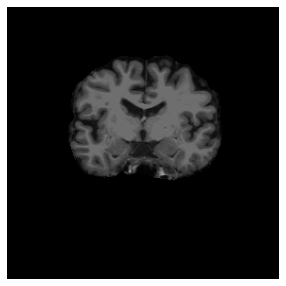

In [ ]:
img_fn = fnames[10]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))

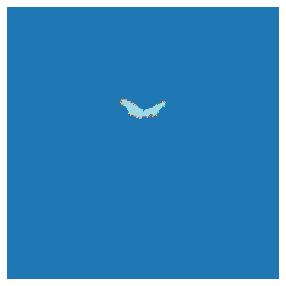

In [ ]:
msk = PILMask.create(get_y_fn(img_fn))
msk.show(figsize=(5,5), alpha=1)

The function `string_starts_with_1` is used to separate the train and validation data sets. 27,5% of the images has an ID that starts with 1. This is a quick and easy solution to split the data without overlapping subjects between the train and the validate sets. It is not an optimal solution, but it works for now. 

In [ ]:
def string_starts_with_1(path):
  return path.name[0] == '1'

In [ ]:
codes = ['no', 'yes']

In [ ]:
def get_n_image_files(n):
  return (lambda x: random.sample(get_image_files(x), n))

Constructing the DataBlock using the DataBlock API. 

In [ ]:
brainseg_block = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes)),
    get_items=get_image_files, #get_n_image_files(200),
    splitter=FuncSplitter(string_starts_with_1),
    get_y=get_y_fn
)

Batch size is set to `16`. When showing the batch, the pictures are shown in color, but grayscale could have possibly been better for visibility.

In [ ]:
dls = brainseg_block.dataloaders(path_im, bs=16)

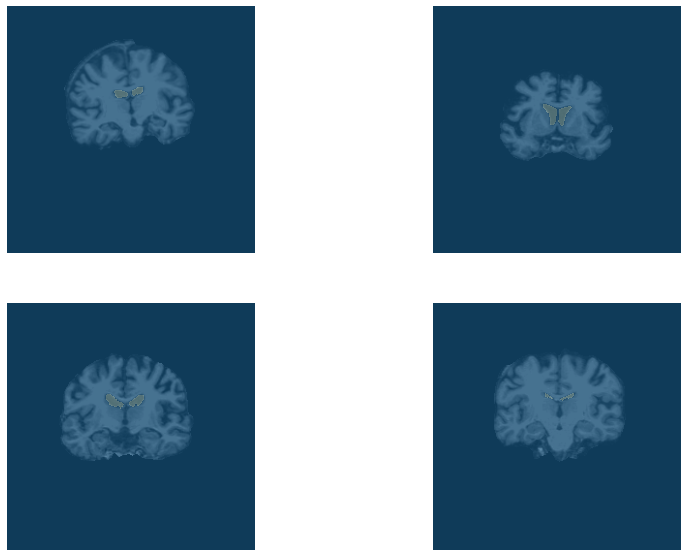

In [ ]:
dls.show_batch(max_n=4, vmin=0, vmax=1, figsize=(14,10))

Checking the sizes of the training- and validation sets in the dataloader. 

In [ ]:
dls.train_ds

(#2774) [(PILImage mode=RGB size=256x256, PILMask mode=L size=256x256),(PILImage mode=RGB size=256x256, PILMask mode=L size=256x256),(PILImage mode=RGB size=256x256, PILMask mode=L size=256x256),(PILImage mode=RGB size=256x256, PILMask mode=L size=256x256),(PILImage mode=RGB size=256x256, PILMask mode=L size=256x256),(PILImage mode=RGB size=256x256, PILMask mode=L size=256x256),(PILImage mode=RGB size=256x256, PILMask mode=L size=256x256),(PILImage mode=RGB size=256x256, PILMask mode=L size=256x256),(PILImage mode=RGB size=256x256, PILMask mode=L size=256x256),(PILImage mode=RGB size=256x256, PILMask mode=L size=256x256)...]

In [ ]:
dls.valid_ds

(#1054) [(PILImage mode=RGB size=256x256, PILMask mode=L size=256x256),(PILImage mode=RGB size=256x256, PILMask mode=L size=256x256),(PILImage mode=RGB size=256x256, PILMask mode=L size=256x256),(PILImage mode=RGB size=256x256, PILMask mode=L size=256x256),(PILImage mode=RGB size=256x256, PILMask mode=L size=256x256),(PILImage mode=RGB size=256x256, PILMask mode=L size=256x256),(PILImage mode=RGB size=256x256, PILMask mode=L size=256x256),(PILImage mode=RGB size=256x256, PILMask mode=L size=256x256),(PILImage mode=RGB size=256x256, PILMask mode=L size=256x256),(PILImage mode=RGB size=256x256, PILMask mode=L size=256x256)...]

### Training

U-Net Learner

In [ ]:
learn = unet_learner(dls, resnet34, metrics=[Dice, JaccardCoeff], self_attention=True, act_cls=Mish)

In [ ]:
learn.summary()

DynamicUnet (Input shape: 16)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 64 x 128 x 128 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                     

Running the learning rate finder tells us that the steepest slope is somewhere between 1e-04 and 1e-05 

SuggestedLRs(lr_min=0.00036307806149125097, lr_steep=4.365158383734524e-05)

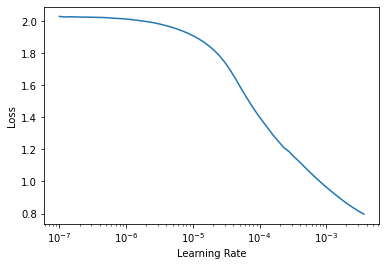

In [ ]:
learn.lr_find()

In [ ]:
lr = 5e-5

In [ ]:
learn.fit_one_cycle(8, slice(lr))

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.128767,0.010534,0.785038,0.646142,17:39
1,0.008080,0.003999,0.908871,0.832964,06:01
2,0.002654,0.002128,0.946279,0.898035,06:01
3,0.002014,0.001981,0.945802,0.897177,06:01
4,0.001615,0.001538,0.958678,0.920635,06:01
5,0.001401,0.001340,0.964150,0.930782,06:00
6,0.001326,0.001319,0.964798,0.931989,06:00
7,0.001207,0.001250,0.966475,0.935125,06:00
8,0.001261,0.001240,0.966730,0.935602,06:00


After training it for some epochs, we reduce the learning rate, unfreeze the model, and continue training it. 

In [ ]:
lrs = slice(lr/400, lr/4)

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(8, lrs)

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.001161,0.001261,0.966294,0.934786,06:13
1,0.001175,0.001208,0.967683,0.937390,06:13
2,0.001193,0.001214,0.967168,0.936422,06:12
3,0.001087,0.001157,0.968860,0.939600,06:13
4,0.001067,0.001149,0.969191,0.940224,06:13
5,0.001102,0.001144,0.969227,0.940291,06:13
6,0.001071,0.001145,0.969238,0.940312,06:13
7,0.001103,0.001143,0.969329,0.940484,06:13


The `valid_loss` is still decreasing at this point, so we could have possibly trained it for a bit longer and achieved a lower score. 

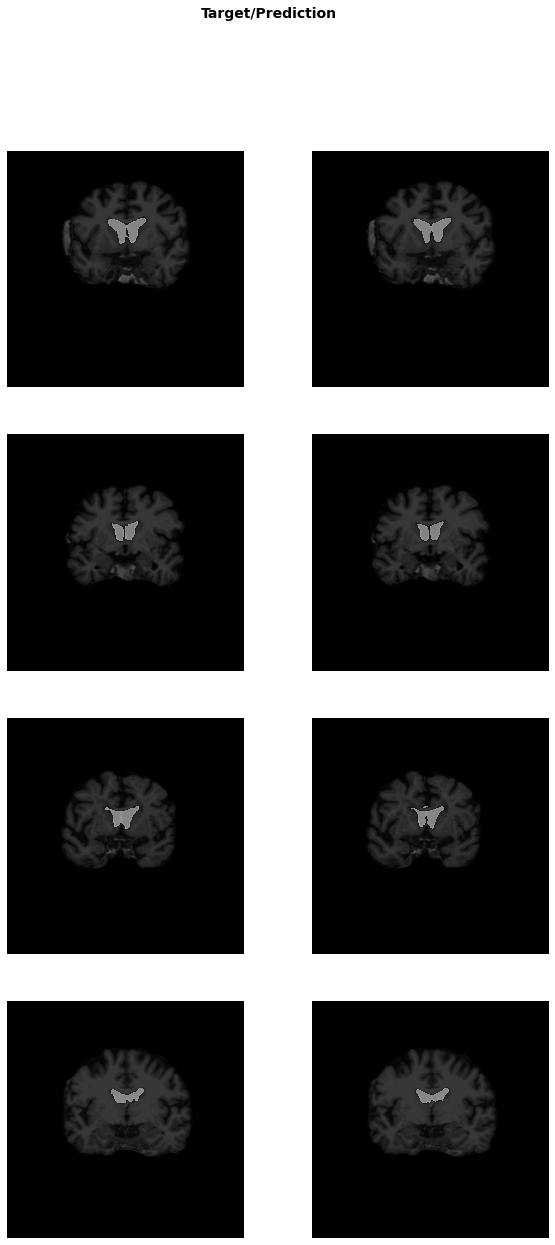

In [ ]:
learn.show_results(max_n=4, vmin=0, vmax=1, figsize=(10,20), cmap="gray")

When printing out the results, they look good. The dice score and jaccard index showed good scores. 

### Exporting the model

In [ ]:
# learn.save('model_1')

Path('models/model_1.pth')

In [ ]:
learn.export('model_2.pkl')


In [ ]:
dl = learn.dls.test_dl(fnames[:5])

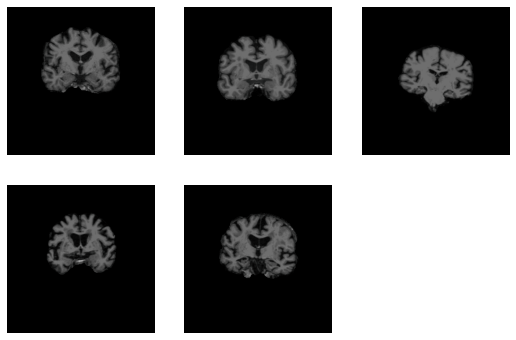

In [ ]:
dl.show_batch()

In [ ]:
preds = learn.get_preds(dl=dl)

In [ ]:
preds[0].shape

torch.Size([5, 2, 256, 256])

In [ ]:
len(codes)

2

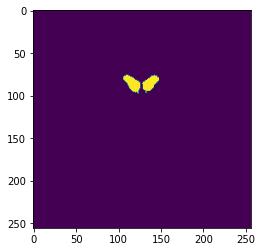

In [ ]:
pred_1 = preds[0][0]
pred_arx = pred_1.argmax(dim=0)
plt.imshow(pred_arx)